# Neural Fitted Q (NFQ)

In many real tasks the state space is combinatorial and enormous and the problem is not just the memory needed for large tables, but the time needed to fill them accurately. It is necessary **to generalize**. Generalization from examples has already been extensively studied, we need to combine reinforcement learning methods with machine learning.

The Cart-pole environment is a classic in reinforcement learning. The state space is low dimensional but continuous. Training is fast, yet still somewhat challenging, and function approximation can help.

Its state space is comprised of four variables: 

- position on the track (x-axis) with a range from –2.4 to 2.4; 
- velocity along the track (x-axis) with a range from –inf to inf; 
- angle with a range of –40 degrees to 40 degrees; 
- velocity at the tip with a range of –inf to inf.

There are two available actions in every state: 

- action 0 applies a –1 force to the cart (push it left)
- action 1 applies a +1 force to the cart (push it right)

The cart reach a terminal state if: 

- the angle is more than 12 degrees away from the vertical position; 
- the center is more than 2.4 units from the center of the track; 
- the episode count reaches 500 time steps. 

The reward function is +1 for every time step.

In [1]:
import gymnasium
cartpole = gymnasium.make('CartPole-v1', render_mode="rgb_array")

In [2]:
print('Observation Space: ', cartpole.observation_space.shape)
print('Action Space: ', cartpole.action_space.n)

Observation Space:  (4,)
Action Space:  2


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
from itertools import count

def show_policy(env, agent, n_episodes=1, max_steps=500):
    for episode in count():

        state = env.reset()[0]

        for step in count():

            if(agent is None):
                action = np.random.choice((0, 1))
            else:
                action = greedy(agent, state)
            
            state, reward, is_terminal, is_truncated, info = env.step(action)
            done = is_terminal or is_truncated
            
            clear_output(wait=True)
            plt.imshow(env.render())
            plt.show()
            
            if done or step > max_steps:
                break

        if episode >= n_episodes-1:
                break

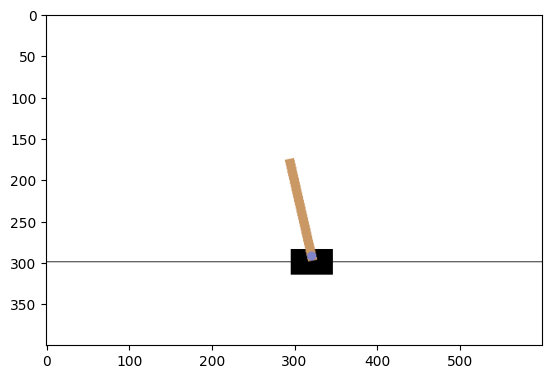

In [4]:
show_policy(cartpole, None, n_episodes=1, max_steps=100)

We can implent a function approximator that take as input the state and provide in output the Q-values for all the actions of that state as a fully connected network using the PyTorch library:

In [5]:
import torch

class Approximator(torch.nn.Module):
    def __init__(self, state_size, action_size):
        super(Approximator, self).__init__()

        # define the activation function (ReLU)
        self.activation = torch.nn.functional.relu

        # defining the input layer
        self.input_layer = torch.nn.Linear(state_size, 512)
        
        # creating the hidden layers 
        self.hidden_layers = torch.nn.ModuleList()
        self.hidden_layers.append(torch.nn.Linear(512, 128))

        # connecting the output layer    
        self.output_layer = torch.nn.Linear(128, action_size)
        
        # decide the device to be used for training
        device = "cpu"
        if torch.cuda.is_available(): device = "cuda:0"
        self.device = torch.device(device)
        self.to(self.device)

    def forward(self, state):
        # take in the raw state and convert it into a tensor
        # also unsqueezing it in order to change it's shape
        if not isinstance(state, torch.Tensor):
            state = torch.Tensor(state)

        # pass it through the input layer
        x = self.activation(self.input_layer(state))

        # then pass for all hidden layers
        for hidden_layer in self.hidden_layers:
            x = self.activation(hidden_layer(x))

        # finally, pass for the output layer
        q_values = self.output_layer(x)
        
        return q_values

    def select_action(self, state):
        with torch.no_grad():
            q_values = self(state).cpu().detach().data.numpy().squeeze()
        return np.argmax(q_values)

In [6]:
state_size = cartpole.observation_space.shape[0]
action_size = cartpole.action_space.n

approximator = Approximator(state_size, action_size)

In [7]:
print(approximator)

Approximator(
  (input_layer): Linear(in_features=4, out_features=512, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=512, out_features=128, bias=True)
  )
  (output_layer): Linear(in_features=128, out_features=2, bias=True)
)


We need to select the optimization method: we use the Adam optimizer, which is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.

In [8]:
optimizer = torch.optim.RMSprop(approximator.parameters(), lr=0.0005)

We have to define the loss function: we use the mean squared error (MSE) loss function.

In [9]:
def optimize(model, optimizer, experiences, gamma,  epochs):
    
    # convert the experiences into separate arrays for each element
    experiences = np.array(experiences, dtype=object)
    experiences = [np.vstack(sars) for sars in experiences.T]

    states, actions, rewards, next_states, is_failures = experiences  
    states = torch.from_numpy(states)
    actions = torch.from_numpy(actions)
    next_states = torch.from_numpy(next_states)
    rewards = torch.from_numpy(rewards)
    is_failures = torch.from_numpy(is_failures)

    for _ in range(epochs):
        # get the values of the Q-function at next state
        # remember to detach, we need to treat these values as constants 
        q_next = model(next_states).detach()
        
        # get the max value of the next state
        max_a_q_next = q_next.max(1)[0].unsqueeze(1)

        # one important step, often overlooked, is to ensure 
        # that failure states are grounded to zero
        max_a_q_next *= (1 - is_failures)

        # calculate the target 
        target = rewards + gamma * max_a_q_next

        # finally, we get the current estimate of Q(s,a)
        q = model(states).gather(1, actions)

        # create the errors
        td_error = target - q

        # calculate the loss
        value_loss = td_error.pow(2).mul(0.5).mean()

        # optimize the online network
        optimizer.zero_grad()
        value_loss.backward()
        optimizer.step()

We need to decide how to balance the exploration-exploitation trade-off: almost any technique would work fine. To keep things simple, we’re going to use an epsilon-greedy strategy:

In [10]:
import random

def epsilon_greedy(approximator, state, action_size, epsilon):
    if random.uniform(0,1) < epsilon:
        return np.random.randint(action_size)
    return approximator.select_action(state)

However, when evaluating the agent, we will use the action greedy with respect to the learned action-value function.

In [11]:
def greedy(approximator, state):
    return approximator.select_action(state)

We need a function in order to evaluate the performance of our agent. We will use the average reward over a number of episodes as our metric.

In [12]:
def evaluate(approximator, env, episodes=1):
    rewards = []
    for _ in range(episodes):
        state = env.reset()[0]
        rewards.append(0)
        while(True):
            action = greedy(approximator, state)
            state, reward, is_terminal, is_truncated, info = env.step(action)
            rewards[-1] += reward
            is_done = is_terminal or is_truncated
            if is_done: 
                break
    return np.mean(rewards)

The full neural fitted Q-iteration (NFQ) algorithm has the following steps:
1. collect E experiences (e.g. 1024 samples)
2. calculate the off-policy TD targets
3. fit the action-value function using MSE and RMSprop
4. repeats steps 2 and 3 K number of times before going back to step 1

In [13]:
import time
from itertools import count

def nfq(env_name, seed, batch_size, epochs, gamma, epsilon, max_episodes, max_time, max_score, episodes_window):

    # create the environment
    env = gymnasium.make(env_name)

    # create the experience buffer 
    experiences = []   

    # set the seeds for reproducibility of results
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    env.np_random = np.random.Generator(np.random.PCG64(seed))

    # access the state and action sizes of the environment 
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    # create the neural models
    q_function = Approximator(state_size, action_size)

    # create the optimizer
    optimizer = torch.optim.RMSprop(q_function.parameters(), lr=0.0005)

    # episode stats trackers 
    episode_steps = []
    episode_return = []
    episode_seconds = []
    episode_scores = []  

    # total stats trackers
    total_step = 0
    training_time = 0
    results = np.empty((max_episodes, 4))
    results[:] = np.nan

    # train until we reach the terminal condition (max episodes)
    for episode in count():
    
        # get the start time of the episode
        episode_start = time.time()

        # set return to 0
        discounted_return = 0

        # reset the environment at the beginning of the episode
        state = env.reset()[0]

        # interact with the environment until the episode is done
        for step in count():
                
            # select the action using the exploration policy
            action = epsilon_greedy(q_function, state, action_size, epsilon)
            
            # perform the selected action
            next_state, reward, is_terminal, is_truncated, info = env.step(action)
            is_done = is_terminal or is_truncated
            is_failure = is_terminal and not is_truncated

            # store the experience
            experiences.append((state, action, reward, next_state, float(is_failure)))

            # if the experience collected so far is enough, we optimize the model 
            if len(experiences) >= batch_size:
                optimize(q_function, optimizer, experiences, gamma,  epochs)
                experiences.clear()
        
            # update current state to next state
            state = next_state
        
            # update the return
            discounted_return += reward
        
            if is_done:
                break

        # timing stuff
        episode_elapsed = time.time() - episode_start

        # evaluate the learned policy after the episode
        score = evaluate(q_function, env)

        # update episode stats
        episode_steps.append(step)
        episode_return.append(discounted_return)
        episode_seconds.append(episode_elapsed)
        episode_scores.append(score)

        # update total stats
        total_step += step
        training_time += episode_elapsed   
    
        # average stats over some recent episodes
        mean_return = np.mean(episode_return[-episodes_window:])
        mean_score = np.mean(episode_scores[-episodes_window:])

        # report results
        results[episode-1] = total_step, mean_return, mean_score, training_time

        # informative print logging  
        message = 'episode {:04}, steps {:06}, score {:05.1f}'
        message = message.format(episode, total_step, mean_score)
        print(message, end='\r', flush=True)

        # check max episodes achievement criteria
        if (episode >= max_episodes):
            print(message, ' --> reached_max_episodes ')
            break

        # check max time achievement criteria
        if (training_time >= max_time):
            print(message, ' --> reached_max_time ')
            break

        # check max score achievement criteria
        if (mean_score >= max_score):
            print(message, ' --> reached_max_score ')
            break

    return q_function, score, results

We can apply the NFQ algorithms to the Cart-pole environment:

In [14]:
env_name = 'CartPole-v1' 

# discount factor and exploration rate
gamma = 0.99  
epsilon = 0.5

# training parameters
batch_size = 1024
epochs = 40

# terminating conditions
max_episodes = 3000
max_time = 20
max_score = 475
episodes_window = 50

# set the seeds for reproducibility of results
seeds = (15, 39, 12, 45, 65)

# variables to collect results
nfq_results = []
best_agent = None
best_eval_score = float('-inf')

# train the agent for each seed
for seed in seeds:     

    # create the agent
    q_function, score, result = nfq(env_name, seed, batch_size, epochs, gamma, epsilon, max_episodes, max_time, max_score, episodes_window)
    
   # save the results the best agent
    nfq_results.append(result)
    if score > best_eval_score:
        best_eval_score = score
        best_agent = q_function
        
nfq_results = np.array(nfq_results)

episode 0791, steps 055376, score 476.1  --> reached_max_score 
episode 1019, steps 072408, score 476.0  --> reached_max_score 
episode 1029, steps 055031, score 476.4  --> reached_max_score 
episode 1192, steps 085617, score 477.9  --> reached_max_score 
episode 1198, steps 080337, score 477.7  --> reached_max_score 


NFQ is not a state-of-the-art solution, however in a somewhat simple environment as the cart-pole, it shows a decent performance:

In [15]:
nfq_max_steps, nfq_max_train_reward, nfq_max_eval_score, nfq_max_time = np.max(nfq_results, axis=0).T
nfq_min_steps, nfq_min_train_reward, nfq_min_eval_score, nfq_min_time = np.min(nfq_results, axis=0).T
nfq_mean_steps, nfq_mean_train_reward, nfq_mean_eval_score, nfq_mean_time = np.mean(nfq_results, axis=0).T
nfq_episodes = np.arange(len(nfq_mean_steps))

We can save results on a file to compare with other algorithms in future lectures:

In [16]:
np.save('nfq_results', nfq_results)

We can plot the training reward:

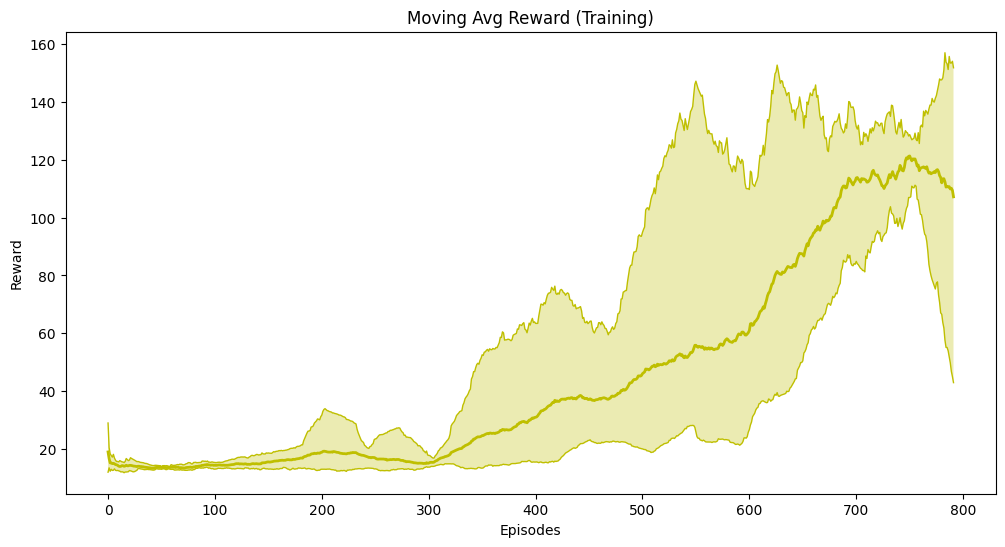

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

plt.title('Moving Avg Reward (Training)')
plt.ylabel('Reward')
plt.xlabel('Episodes')

plt.plot(nfq_max_train_reward, 'y', linewidth=1)
plt.plot(nfq_min_train_reward, 'y', linewidth=1)
plt.plot(nfq_mean_train_reward, 'y', linewidth=2)
plt.fill_between(nfq_episodes, nfq_min_train_reward, nfq_max_train_reward, facecolor='y', alpha=0.3)

plt.show()

Plotting the reward during evaluation steps shows the best performance we can obtain from the agent. Notice that the reward is not stable, it fluctuates a lot.  

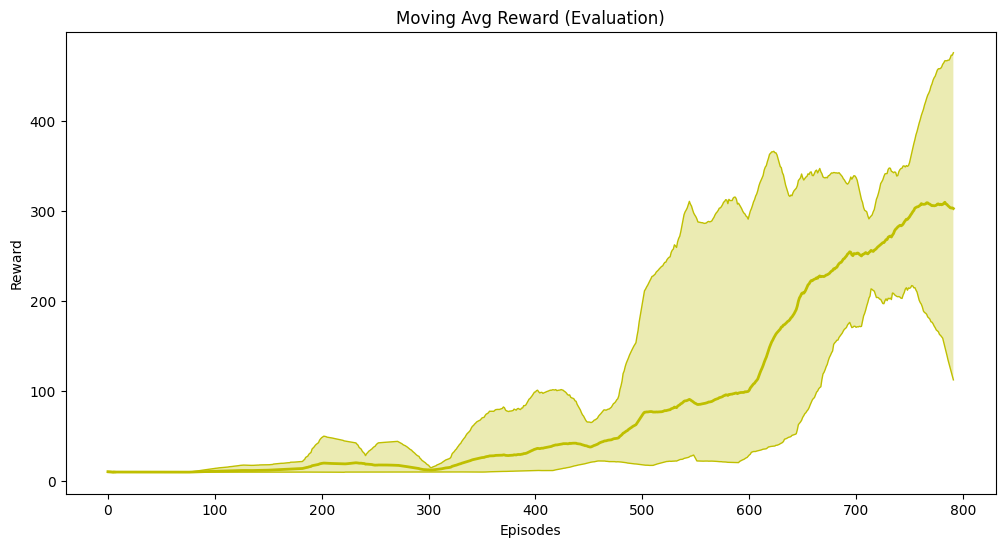

In [18]:
plt.figure(figsize=(12,6))

plt.title('Moving Avg Reward (Evaluation)')
plt.ylabel('Reward')
plt.xlabel('Episodes')

plt.plot(nfq_max_eval_score, 'y', linewidth=1)
plt.plot(nfq_min_eval_score, 'y', linewidth=1)
plt.plot(nfq_mean_eval_score, 'y', linewidth=2)
plt.fill_between(nfq_episodes, nfq_min_eval_score, nfq_max_eval_score, facecolor='y', alpha=0.3)

plt.show()

Plotting the total steps per episode shows that the agent is learning something, but it is not learning fast enough. The main issue with NFQ is that it takes too many steps to get decent performance. In other words, in terms of sample efficiency, NFQ does poorly.

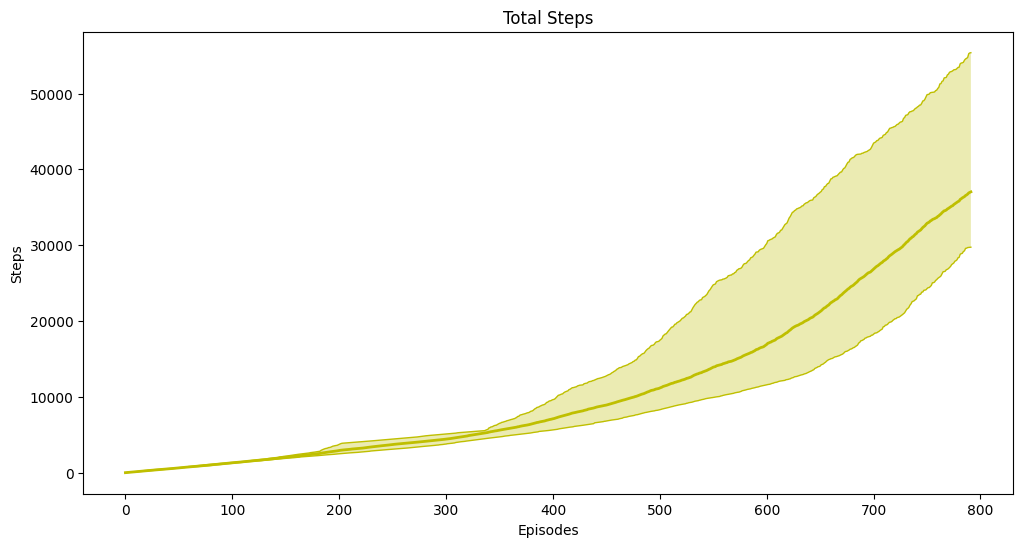

In [19]:
plt.figure(figsize=(12,6))

plt.title('Total Steps')
plt.ylabel('Steps')
plt.xlabel('Episodes')

plt.plot(nfq_max_steps, 'y', linewidth=1)
plt.plot(nfq_min_steps, 'y', linewidth=1)
plt.plot(nfq_mean_steps, 'y', linewidth=2)
plt.fill_between(nfq_episodes, nfq_min_steps, nfq_max_steps, facecolor='y', alpha=0.3)

plt.show()

The next plot is related to time. We can see how NFQ takes approximately several seconds on average to pass the environment.

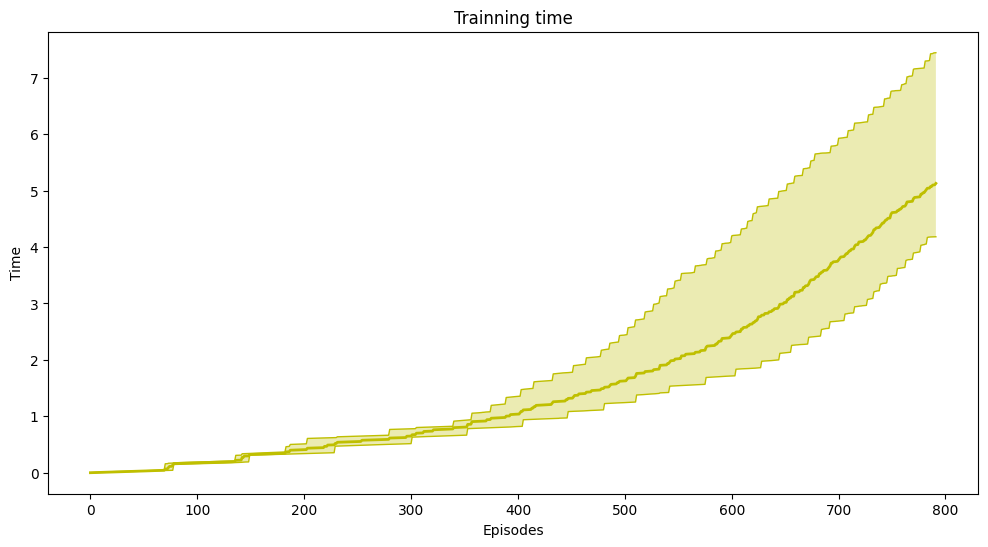

In [20]:
plt.figure(figsize=(12,6))

plt.title('Trainning time')
plt.ylabel('Time')
plt.xlabel('Episodes')

plt.plot(nfq_max_time, 'y', linewidth=1)
plt.plot(nfq_min_time, 'y', linewidth=1)
plt.plot(nfq_mean_time, 'y', linewidth=2)
plt.fill_between(nfq_episodes, nfq_min_time, nfq_max_time, facecolor='y', alpha=0.3)

plt.show()

We can display the trained model behavior:

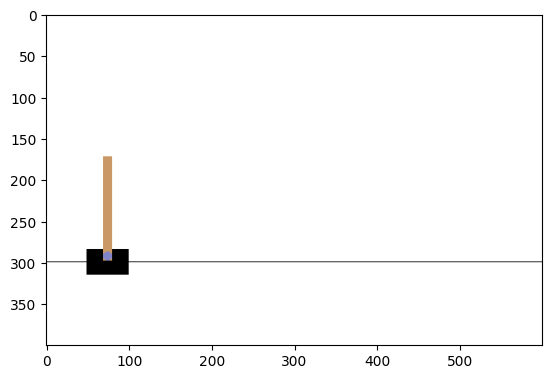

In [21]:
show_policy(cartpole, best_agent, n_episodes=1, max_steps=500)